<a href="https://colab.research.google.com/github/amirhosseinzinati/Cat-dog-classification-using-CNN/blob/main/Cat_And_Dog_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import opendatasets as od
import numpy as np
import pandas as pd
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,Activation,BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
#from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import cv2 as cv

In [4]:
od.download("https://www.kaggle.com/datasets/tongpython/cat-and-dog")

Skipping, found downloaded files in "./cat-and-dog" (use force=True to force download)


In [5]:
#The paths to the dataset.
training_path = './cat-and-dog/training_set/training_set/'
test_path = './cat-and-dog/test_set/test_set/'


In [6]:
#Plot some images in the dataset.
def plot_image(path, int_type):
    _path = path
    label = None
    if int_type == 0:
        _path = _path + "/" + "cats"
        label = 0
    else:
        _path = _path + "/" + "dogs"
        label = 1
    
    plt.figure(figsize=(30, 30))
    plt.subplots_adjust(top=None, bottom=None, left=None, right=None, wspace=0.2, hspace=0.5)
    
    lst_img_name = os.listdir(_path)
    for i in range(1, 17, 1):
        th = np.random.randint(0, len(lst_img_name) - 1)
        plt.subplot(4, 4, i)
        img = _path + "/" + lst_img_name[th]
        img = cv.imread(img)
        plt.imshow(img)
        if label == 0:
            plt.title("Cat")
        else:
            plt.title("Dog")

In [ ]:
plot_image(training_path, 0)

In [ ]:
plot_image(training_path, 1)

In [7]:
# مشخص کردن مشخصات تصاویر
Image_Width=200
Image_Height=200
Image_Size=(Image_Width,Image_Height)
Image_Channels=3
Batch_Size=32

In [8]:
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [11]:
# Getting the train and test dataset into tensorflow batches
training_set = image_dataset_from_directory(
    directory=training_path,
    class_names=['cats', 'dogs'],
    image_size=Image_Size,
    batch_size=Batch_Size
)
test_set = image_dataset_from_directory(
    directory=test_path,
    class_names=['cats', 'dogs'],
    image_size=Image_Size,
    batch_size=Batch_Size,
    
)

Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


In [9]:
# Getting the train and test dataset into tensorflow batches
training_set = image_dataset_from_directory(training_path,
                                             batch_size=Batch_Size,
                                             image_size=Image_Size,
                                             shuffle=True,
                                             seed=123,
                                             validation_split=0.2,
                                             subset='training')

val_set = image_dataset_from_directory(directory=training_path,
                                           batch_size=Batch_Size,
                                           image_size=Image_Size,
                                           shuffle=True,
                                           validation_split=0.2,
                                           subset='validation',
                                           seed=123)

test_set = image_dataset_from_directory(test_path,
                                            batch_size=Batch_Size,
                                            image_size=Image_Size,
                                            shuffle=True,
                                            seed=123)

Found 8005 files belonging to 2 classes.
Using 6404 files for training.
Found 8005 files belonging to 2 classes.
Using 1601 files for validation.
Found 2023 files belonging to 2 classes.


In [20]:
# Make CNN Model
model=Sequential()

model.add(Conv2D(128,(3,3),activation='relu',padding='same',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))


In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 200, 200, 128)     3584      
                                                                 
 batch_normalization_4 (Batc  (None, 200, 200, 128)    512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 100, 100, 128)    0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 100, 100, 128)     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 256)     295168    
                                                                 
 batch_normalization_5 (Batc  (None, 100, 100, 256)   

In [22]:
epochs = 50
earlystop = EarlyStopping(patience = 10)
callbacks = [earlystop]

In [23]:
model.compile(loss='binary_crossentropy',
  optimizer='adam',metrics=['accuracy'],run_eagerly=True)

In [ ]:
history = model.fit(training_set, validation_data=test_set, epochs=epochs, callbacks=callbacks)

Epoch 1/50
201/201 [==============================] - 91s 452ms/step - loss: 0.8409 - accuracy: 0.6004 - val_loss: 0.8900 - val_accuracy: 0.5971
Epoch 2/50
201/201 [==============================] - 91s 452ms/step - loss: 0.6106 - accuracy: 0.6810 - val_loss: 0.6932 - val_accuracy: 0.6110
Epoch 3/50
201/201 [==============================] - 92s 455ms/step - loss: 0.5336 - accuracy: 0.7285 - val_loss: 0.8287 - val_accuracy: 0.5640
Epoch 4/50
201/201 [==============================] - 91s 454ms/step - loss: 0.4916 - accuracy: 0.7601 - val_loss: 0.7535 - val_accuracy: 0.6367
Epoch 5/50
201/201 [==============================] - 96s 475ms/step - loss: 0.4608 - accuracy: 0.7790 - val_loss: 0.7658 - val_accuracy: 0.7039
Epoch 6/50
201/201 [==============================] - 92s 456ms/step - loss: 0.4239 - accuracy: 0.8047 - val_loss: 0.5506 - val_accuracy: 0.7316
Epoch 7/50
 23/201 [==>...........................] - ETA: 1:15 - loss: 0.5070 - accuracy: 0.7541

In [ ]:
# Saving Model
model.save("model1_cats_and_dogs.h5")

In [15]:
# Plot the chart for accuracy and loss on both training and validation
def plot_acc_loss(history):
    acc = history.history['accuracy']
    acc_val = history.history['val_accuracy']
    
    loss = history.history['loss']
    loss_val = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'r', label='Traning Accuracy')
    plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    
    plt.figure()
    
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, loss_val, 'b', label='Validation Loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    
    plt.show()

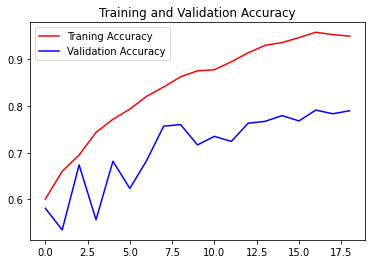

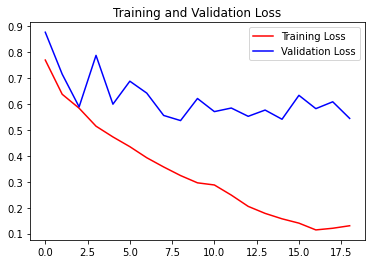

In [16]:
#Plot accuracy and loss.
plot_acc_loss(history)

1/1 [==============================] - 0s 37ms/step


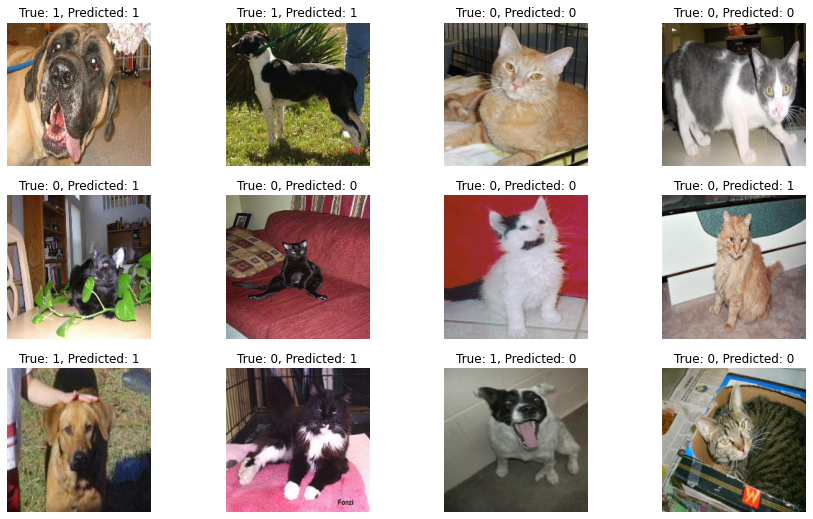

In [26]:

plt.figure(figsize=(15, 9))

def predict(imgs):
    pred = []
    for i in model.predict(images.numpy().astype('uint8')):
        if i[0] > .5:
            pred.append(1)
        else:
            pred.append(0)
    return pred
    
for images, labels in test_set.take(1):
    pred = predict(images)
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'True: {int(labels[i])}, Predicted: {pred[i]}')
        plt.axis('off')

In [22]:
#Cats
test_model(test_set, model, 0)

TypeError: ignored

In [23]:
test_model(test_set, model, 1)


TypeError: ignored

In [ ]:
training_set, validation_data=test_set